# Introduction
RCTD is a statistical method for learning cell types from spatial transcriptomics data. We will define cell type profiles using an annotated single nucleus RNA-sequencing

## Single cell reference
In order to run RCTD, the first step is to process the single cell reference. The reference is created using the RCTD reference constructor function:

1) counts: A matrix representing Digital Gene expression. 
2) cell_types: A named factor of cell type for each cell
3) nUMI: a named list of total counts appearing at each pixel.

In [2]:
# Load in/preprocess your data
refdir <- system.file("extdata", "Reference/Vignette", package = "spacexr")
counts <- read.csv(file.path(refdir, "dge.csv")) # load in the count matrix
rownames(counts) <- counts[,1]; counts[,1] <- NULL # move the first column to rownames
meta_data <- read.csv(file.path(refdir, "meta_data.csv")) # load in the metadata (barcodes, clusters, and nUMI)
cell_types <- meta_data$cluster; names(cell_types) <- meta_data$barcode # extract the cell types and create the named list
cell_types <- as.factor(cell_types)
nUMI <- meta_data$nUMI; names(nUMI) <- meta_data$barcode # extract the nUMI and create the named list

## Create the reference Object
reference <- spacexr::Reference(counts, cell_types, nUMI)


Warning message in spacexr::Reference(counts, cell_types, nUMI):
“Reference: nUMI does not match colSums of counts. If this is unintended, please correct this discrepancy. If this is intended, there is no problem.”


In [3]:
print(dim(reference@counts)) # 
table(reference@cell_types)

[1] 384 475



 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 

# Spatial transcriptomic data
Let's load the Spatial transcriptomic data into a *SpatialRNA* object. Similarly to the reference, we will load the data into R, and then pass the data into the RCTD *SpatialRNA* constructor function, which requires 3 parameters:
- coords: numeric data frame representing the spatial pixel locations, rownames must be pixel names and there should be two columns 'x' and 'y'
- counts: matrix representing Digital Gene Expression, rownames should be genes and colnames represent barcodes pixel names. Counts should be untrasformed count-level data.
- nUMI: list of total counts or UMI's appearing at each pixel

In [8]:
datadir <- system.file("extdata", "SpatialRNA/Vignette", package="spacexr")
counts <- read.csv(file.path(datadir, "MappedDGEForR.csv")) # counts (G x S)
coords <- read.csv(file.path(datadir, "BeadLocationsForR.csv")) # coords for each barcode (spatial location) (S x 2)
rownames(counts) <- counts[,1]; counts[,1] <- NULL # move the first column to rownames
rownames(coords) <- coords$barcodes; coords$barcodes <- NULL # move the first column to rownames
nUMI <- colSums(counts) # nUMI for each barcode

## Create the SpatialRNA Object
puck <- spacexr::SpatialRNA(coords, counts, nUMI)

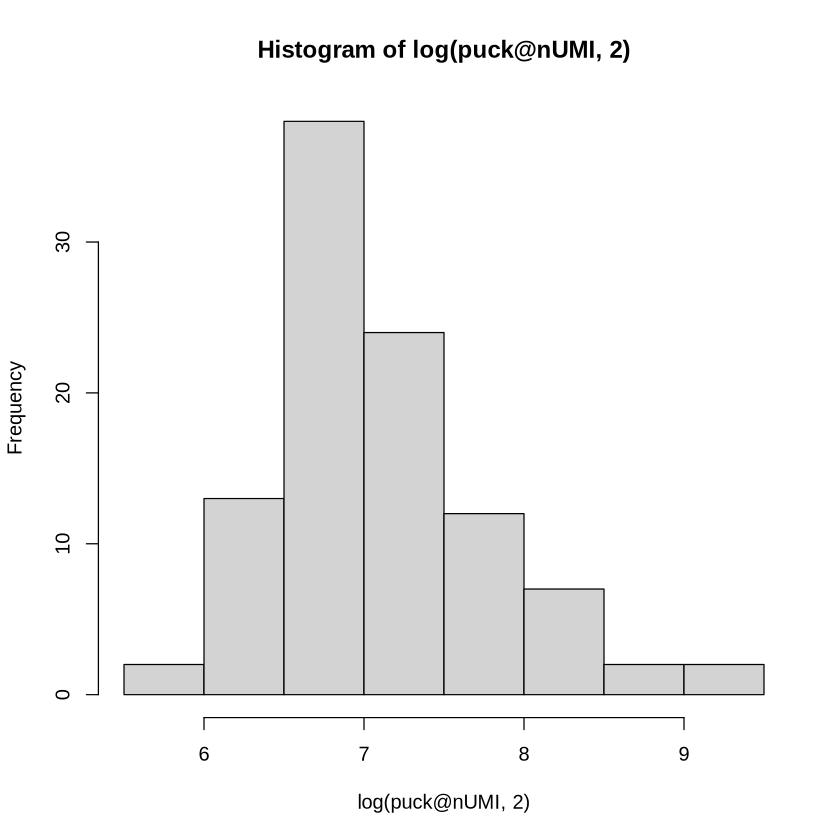

In [9]:
hist(log(puck@nUMI,2))

                      x        y
TTGGACGTTTCAAT 3411.273 2254.628
CACGGCCATATTGC 4613.200 1476.200
CGCCCCCCACCCCT 4707.968 1408.806
CCCCCCCCATTGAA 5149.506 2548.747
CGCTTGGCATTTAC 4121.016 2071.172
CGTGAGTTTCTCCT 4015.358 2927.792


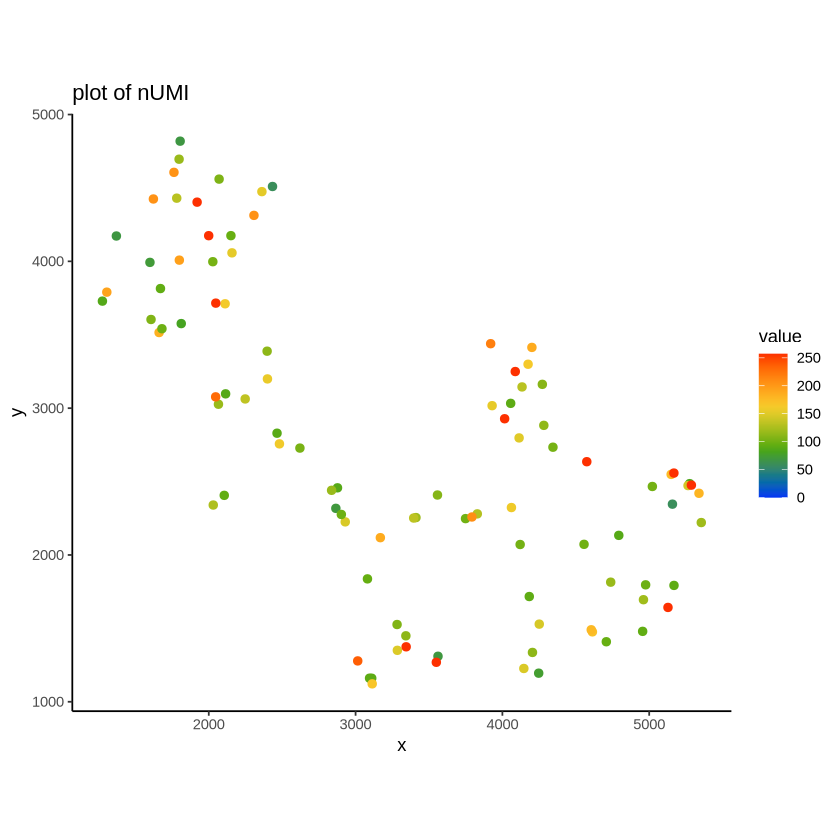

In [14]:
print(head(puck@coords))
barcodes <- colnames(puck@counts)

## This list can be restricted if you want to crop the puck e.g. to a region of interest
spacexr::plot_puck_continuous(puck,
    barcodes,
    puck@nUMI,
    ylimit = c(0, round(quantile(puck@nUMI, 0.9))),
    size=2,
    title="plot of nUMI")

# Create RCTD object

Now that we have loaded our reference scRNA-seq data and our Spatial Trascriptomics data. We can create the RCTD object to the constructor function `create.RCTD` which needs some parameters:
- max_cores
- gene_cutoff
- fc_cutoff
- gene_cutoff_reg
- fc_cutoff_reg
- UMI_min
- UMI_max

In [15]:
myRCTD <- spacexr::create.RCTD(puck, reference, max_cores = 4)

Begin: process_cell_type_info

process_cell_type_info: number of cells in reference: 475

process_cell_type_info: number of genes in reference: 384




 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 


End: process_cell_type_info

create.RCTD: getting regression differentially expressed genes: 

get_de_genes: 1 found DE genes: 35

get_de_genes: 2 found DE genes: 38

get_de_genes: 3 found DE genes: 57

get_de_genes: 4 found DE genes: 18

get_de_genes: 5 found DE genes: 26

get_de_genes: 6 found DE genes: 16

get_de_genes: 7 found DE genes: 20

get_de_genes: 8 found DE genes: 46

get_de_genes: 9 found DE genes: 59

get_de_genes: 10 found DE genes: 51

get_de_genes: 11 found DE genes: 44

get_de_genes: 12 found DE genes: 19

get_de_genes: 13 found DE genes: 27

get_de_genes: 14 found DE genes: 55

get_de_genes: 15 found DE genes: 51

get_de_genes: 16 found DE genes: 57

get_de_genes: 17 found DE genes: 50

get_de_genes: 18 found DE genes: 75

get_de_genes: 19 found DE genes: 56

get_de_genes: total DE genes: 313

create.RCTD: getting platform effect normalization differentially expressed genes: 

get_de_genes: 1 found DE genes: 58

get_de_genes: 2 found DE genes: 61

get_de_genes: 3 fou

In [17]:
myRCTD <- spacexr::run.RCTD(myRCTD, doublet_mode = 'doublet')

fitBulk: decomposing bulk

chooseSigma: using initial Q_mat with sigma =  1

Likelihood value: 1970.41846749876

Sigma value:  0.84

Likelihood value: 1964.49883874699

Sigma value:  0.84



## RCTD results
we ar eparticularly interested in the weights, a data frame of cell type weights or each pixel. The results of "doublet_mode" are stored in weights_doublet

Important columns are:
- spot_class: a factor variable for RCTD classificaiton in doublet mode: "singlet" (1 cell type per pixel), "doublet_certain" (2 cell types on pixel), "doublet_uncertain" (2 cell types but confident of 1), "reject"
- first_type: first cell type predicted on the bead
- second_type: second cell type predicted on the bead

In [28]:
results <- myRCTD@results

# normalize the cell type proportions to sum to 1
norm_weights = spacexr::normalize_weights(results$weights)

cell_type_names <- myRCTD@cell_type_info$info[[2]]

spatialRNA <- myRCTD@spatialRNA

resultsdir <- "RCTD_plots"
dir.create(resultsdir)

Warning message in dir.create(resultsdir):
“'RCTD_plots' already exists”


NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL


pdf 
  2

pdf 
  2

NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL


pdf 
  2

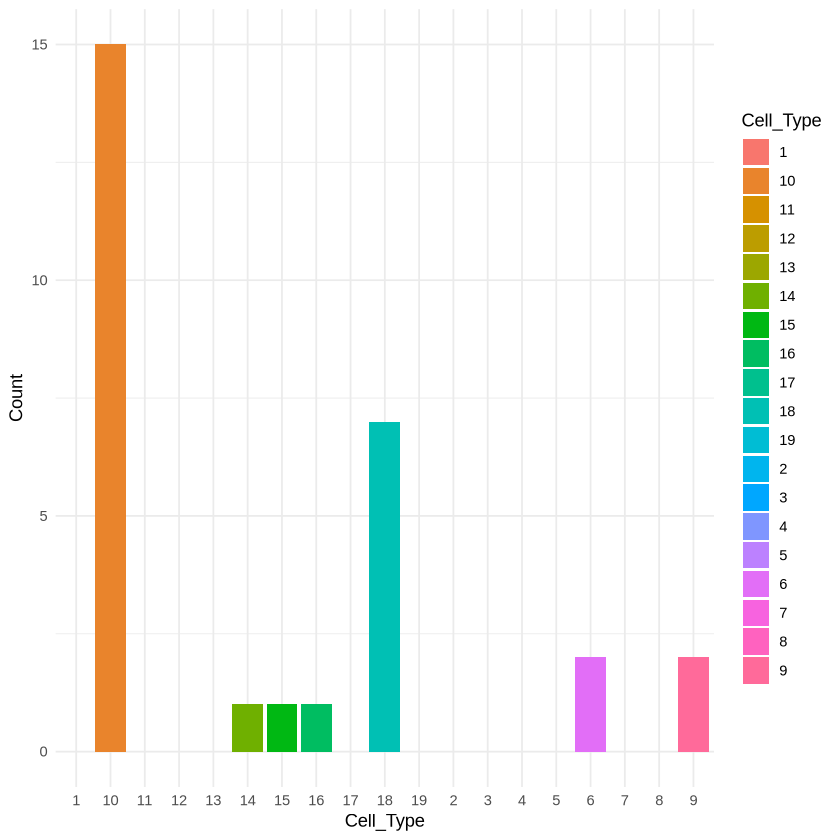

In [31]:
spacexr::plot_weights(cell_type_names,
                    spatialRNA,
                    resultsdir,
                    norm_weights)
# Plots all weights for each cell type as in full_mode. (saved as 
# 'results/cell_type_weights.pdf')
spacexr::plot_weights_unthreshold(cell_type_names, spatialRNA, resultsdir, norm_weights) 
# Plots the weights for each cell type as in doublet_mode. (saved as 
# 'results/cell_type_weights_doublets.pdf')
spacexr::plot_weights_doublet(cell_type_names, spatialRNA, resultsdir, results$weights_doublet, 
                     results$results_df) 
# Plots the number of confident pixels of each cell type in 'full_mode'. (saved as 
# 'results/cell_type_occur.pdf')
spacexr::plot_cond_occur(cell_type_names, resultsdir, norm_weights, spatialRNA)